In [1]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline

import sys
sys.path.append('../src')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from nbsupport import insertions as nb_ins

sns.set_style('white')

# Insertion statistics

## All insertions (incl. non-cis)

Number of insertions: 3780
Insertions per sample: 24.0


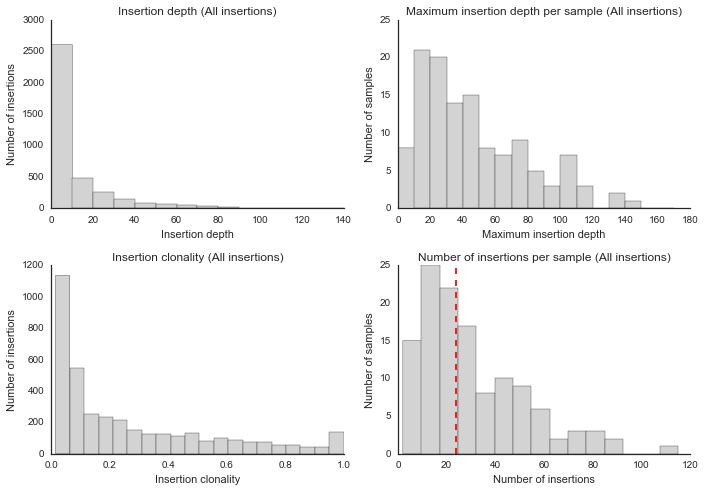

In [2]:
insertions_all = (pd.read_csv('../data/processed/shear_splink/all/insertions.txt',
                              sep='\t', dtype={'sample': 'category'})
                    .pipe(nb_ins.annotate_with_clonality))

# Print some basic statistics.
print('Number of insertions: {}'.format(insertions_all['id'].nunique()))
print('Insertions per sample: {}'.format(
        insertions_all.groupby('sample')['id'].nunique().median()))

# Plot stats.
fig, _ = nb_ins.plot_insertion_stats(
    insertions_all, suffix=' (All insertions)',
    fig_kws={'figsize': (10, 7)}, color='lightgrey')

# Plot again for paper.
with sns.plotting_context('paper', font_scale=0.7):
    fig, _ = nb_ins.plot_insertion_stats(
        insertions_all, fig_kws=dict(figsize=(6, 4)),
        color='lightgrey', suffix=' (All insertions)')

fig.savefig('../reports/supplemental/figures/fig_s3_ins_stats.pdf', bbox_inches='tight')
plt.close(fig)

## CIS insertions

Number of insertions: 623
Number of CIS: 62
Insertions per sample: 5.0
Number of genes: 32


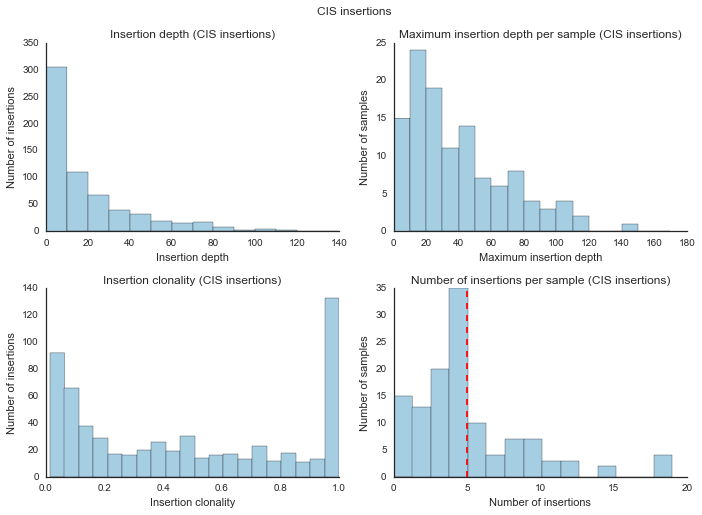

In [3]:
# Read sample definition.
samples = pd.read_csv('../data/raw/samples.txt', sep='\t')

# Read insertions and cis sites.
insertions = (pd.read_csv('../data/processed/shear_splink/all/insertions.cis.rbm.txt', sep='\t')
                .assign(sample=lambda df: pd.Categorical(df['sample'], categories=samples['sample']))
                .pipe(nb_ins.annotate_with_clonality))

cis_sites = pd.read_csv('../data/processed/shear_splink/all/insertions.cis.sites.txt', sep='\t')

# Print some basic statistics.
print('Number of insertions: {}'.format(insertions['id'].nunique()))
print('Number of CIS: {}'.format(cis_sites.shape[0]))
print('Insertions per sample: {}'.format(
        insertions.groupby('sample')['id'].nunique().median()))
print('Number of genes: {}'.format(insertions['gene_name'].nunique()))

# Plot some basis stats.
fig, _ = nb_ins.plot_insertion_stats(
    insertions, fig_kws={'figsize': (10, 7)}, suffix=' (CIS insertions)',
    color=sns.color_palette('Paired')[0])
fig.suptitle('CIS insertions', fontsize=12, y=1.02);

# Plot again for paper.
with sns.plotting_context('paper', font_scale=0.7):
    fig, _ = nb_ins.plot_insertion_stats(
        insertions, fig_kws=dict(figsize=(6, 4)), suffix=' (CIS insertions)',
        color=sns.color_palette('Paired')[0])

fig.savefig('../reports/supplemental/figures/fig_s3_cis_stats.pdf', bbox_inches='tight')
plt.close(fig)

# Sample overview

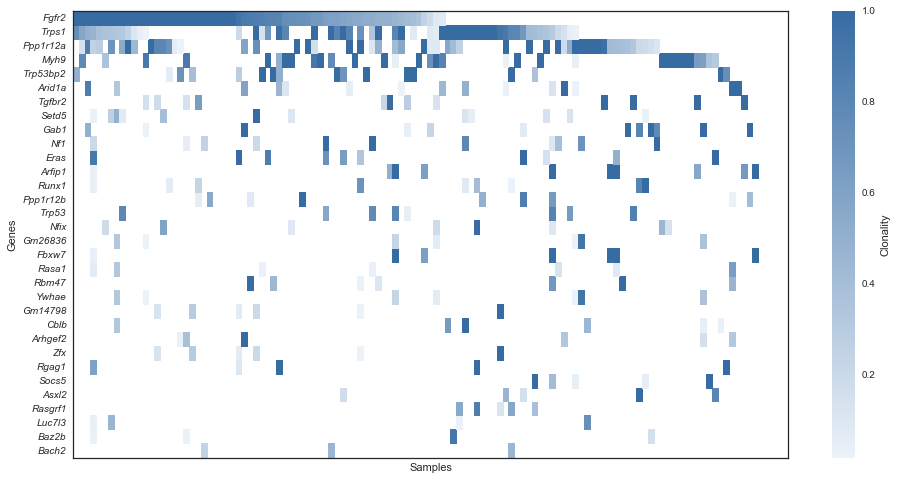

In [4]:
from nbsupport import insertions as nb_ins

fig, ax = plt.subplots(figsize=(16, 8))
nb_ins.plot_insertion_matrix(insertions, ax=ax)

# Draw again for paper.
with sns.plotting_context('paper', font_scale=0.7):
    fig, ax = plt.subplots(figsize=(9.6, 4))
    nb_ins.plot_insertion_matrix(insertions, ax=ax) 
    fig.savefig('../reports/figures/fig_3_overview.pdf', bbox_inches='tight')
    plt.close()

# Subtype enrichment

In [5]:
from IPython.display import display
from nbsupport.enrichment import associations as nb_assoc


# Get subtypes.
nmf_subtypes = pd.read_csv('../data/processed/nmf/subtypes.txt',
                           sep='\t', index_col=0)

# Summarize gene clonality per sample.
sample_mat = nb_ins.clonality_matrix(insertions).T > 0
    
# Test individual clusters.
res_subtype = nb_assoc.test_associations(
    nmf_subtypes[['subtype']], sample_mat,
    alternative='greater', labels=('cluster', 'gene'))

print('Subtypes')
display(res_subtype.query('p_value_corr < 0.1'))

# Test merged clusters.
res_subtype_merged = nb_assoc.test_associations(
    nmf_subtypes[['subtype_merged']], sample_mat,
    alternative='greater', labels=('cluster', 'gene'))

print('Merged subtypes')
display(res_subtype_merged.query('p_value_corr < 0.1'))

Subtypes


,cluster,gene,p_value,p_value_corr
66,subtype_ILC-2,Arid1a,0.003147,0.080575
71,subtype_ILC-2,Eras,0.000305,0.019492
84,subtype_ILC-2,Rasgrf1,0.000932,0.039765
93,subtype_ILC-2,Trps1,0.002052,0.065679
122,subtype_Squamous-like,Tgfbr2,0.000002,0.000227


Merged subtypes


,cluster,gene,p_value,p_value_corr
61,subtype_merged_ILC,Trps1,0.000484,0.023242
90,subtype_merged_Squamous-like,Tgfbr2,0.000002,0.000170


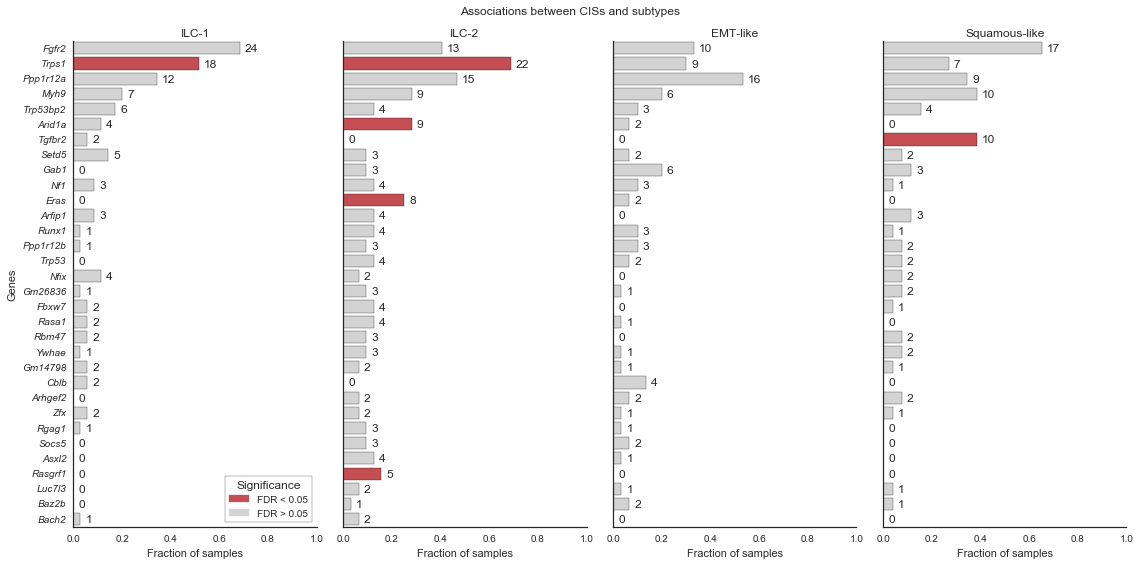

In [6]:
subtype_order = ['ILC-1', 'ILC-2', 'EMT-like', 'Squamous-like']

# Rank genes by frequency.
ranked_genes = list(insertions.groupby('gene_name')['sample']
                              .nunique().sort_values(ascending=False)
                              .index)

# Get associations with subtypes.
subtype_assocs = {cluster.split('_')[1]: list(grp['gene'])
                  for cluster, grp in res_subtype.query('p_value_corr < 0.1')
                                                 .groupby('cluster')}

# Add Trps1 (enriched in combined ILC groups).
if 'ILC-1' not in subtype_assocs:
    subtype_assocs['ILC-1'] = []

subtype_assocs['ILC-1'].append('Trps1') 
subtype_assocs['ILC-2'].append('Trps1') 

# Plot counts per subtype for all genes.
shared_kws = dict(
    highlight=subtype_assocs,
    highlight_labels=('FDR < 0.05', 'FDR > 0.05'),
    legend_kws=dict(title='Significance'),
    col_order=subtype_order)

g = nb_ins.plot_subtype_counts(
    insertions, nmf_subtypes['subtype'], order=ranked_genes,
    size=8, aspect=0.5, highlight=subtype_assocs,
    highlight_labels=('FDR < 0.05', 'FDR > 0.05'),
    legend_kws=dict(title='Significance'),
    col_order=subtype_order)

g.fig.suptitle('Associations between CISs and subtypes', fontsize=12)
g.fig.subplots_adjust(top=0.92)

# Draw again for paper with slightly different scaling.
with sns.plotting_context('paper', font_scale=0.7):
    g = nb_ins.plot_subtype_counts(
        insertions, nmf_subtypes['subtype'], size=3.8, order=ranked_genes,
        aspect=0.45, annotate_kws={'fontsize': 5}, **shared_kws)
    g.fig.suptitle('Associations between CISs and subtypes', fontsize=7)
    g.fig.subplots_adjust(top=0.9)

g.savefig('../reports/supplemental/figures/fig_s4_subtype_assocs.pdf', bbox_inches='tight')
plt.close(g.fig);

# Hit prioritization

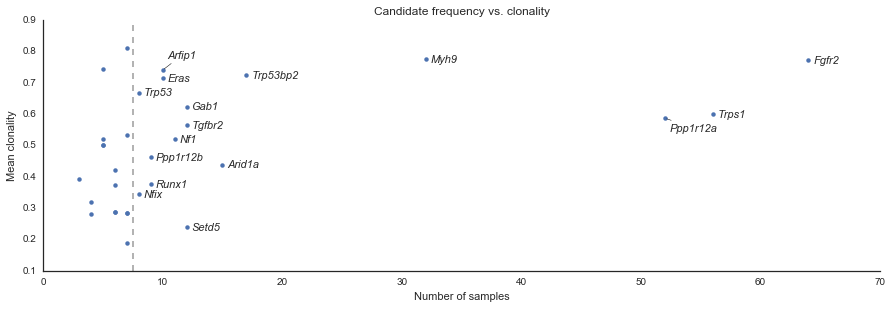

In [7]:
# Label offsets.
offsets = {'Ppp1r12a': (5, -10),
           'Fbxw7': (0, 45),
           'Arfip1': (5, 15)}

# Draw plot.
fig, ax = plt.subplots(figsize=(15, 4.5))
nb_ins.plot_gene_clonality(
    insertions, ax=ax, label_offsets=offsets, label_min_freq=8,
    label_kws=dict(fontstyle='italic', fontsize=11))
ax.axvline(7.5, color='darkgrey', linestyle='dashed', zorder=0)

# Draw again for paper with slightly different scaling.
offsets = {
    'Arfip1': (8, 8),
    'Nfix': (5, -10),
    'Eras': (5, 2),
    'Gab1': (3, 3),
    'Tgfbr2': (3, 3),
    'Nf1': (10, 0),
    'Ppp1r12a': (5, 10)
}

with sns.plotting_context('paper', font_scale=0.7):
    fig, ax = plt.subplots(figsize=(8.5, 1.7))
    nb_ins.plot_gene_clonality(
        insertions, ax=ax, label_offsets=offsets, label_min_freq=8,
        label_kws=dict(fontstyle='italic', fontsize=7))
    ax.set_title('')
    ax.axvline(7.5, color='darkgrey', linestyle='dashed', zorder=0)

fig.savefig('../reports/supplemental/figures/fig_s5_freq_clonality.pdf', bbox_inches='tight')
plt.close(fig)

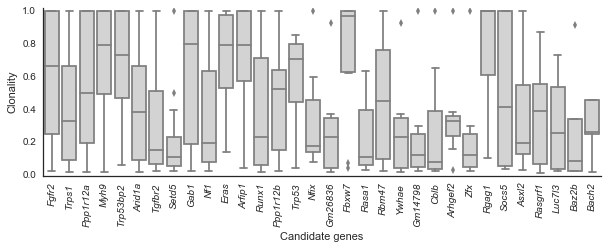

In [8]:
# Order genes by their ranking.
rank_order = list(insertions.groupby('gene_name')
                            ['sample'].nunique()
                            .sort_values(ascending=False)
                            .index)

# Plot clonality of insertions.
fig, ax = plt.subplots(figsize=(10, 3))
sns.boxplot(data=insertions, x='gene_name', y='clonality',
            ax=ax, color='lightgrey', order=rank_order)

ax.set_xlabel('Candidate genes')
ax.set_ylabel('Clonality')
ax.set_ylim(0, 1.02)

plt.setp(ax.get_xticklabels(), rotation=90, fontstyle='italic')
sns.despine()

# Plot again for paper.
with sns.plotting_context('paper', font_scale=0.7): 
    fig, ax = plt.subplots(figsize=(8.5, 1.5))
    sns.boxplot(data=insertions, x='gene_name', y='clonality',
                ax=ax, color='lightgrey', order=rank_order)

    ax.set_xlabel('Candidate genes')
    ax.set_ylabel('Clonality')
    ax.set_ylim(0, 1.02)
    
    sns.despine()

    plt.setp(ax.get_xticklabels(), rotation=90, fontstyle='italic')

fig.savefig('../reports/supplemental/figures/fig_s5_clonality.pdf',
            bbox_inches='tight')    
plt.close(fig)

# Orientation bias

## Sense/antisense fraction

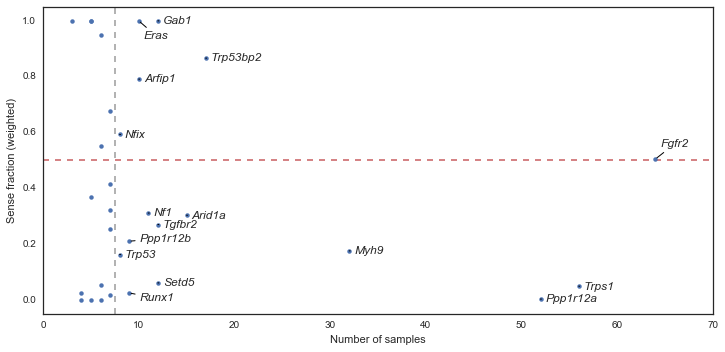

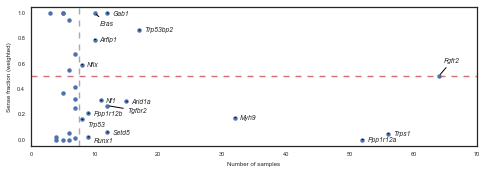

In [9]:
label_offsets = {'Eras': (5, -15), 
                 'Fbxw7': (5, 15), 
                 'Fgfr2': (5, 15),
                 'Ppp1r12b': (10, 3),
                 'Rasgrf1': (-5, -50),
                 'Runx1': (10, -5)}

fig = nb_ins.plot_orientation_bias(
    insertions, min_samples=7.5,
    label_offsets=label_offsets)

# Draw again for paper.
label_offsets = {'Eras': (5, -10), 
                 'Fbxw7': (3, 5), 
                 # 'Nf1': (-15, -5), 
                 'Tgfbr2': (20, -5),
                 'Fgfr2': (5, 15),
                 # 'Ppp1r12b': (10, 3),
                 'Trp53': (5, -5),
                 'Rasgrf1': (-5, -25),
                 'Runx1': (5, -4)}

with sns.plotting_context('paper', font_scale=0.7):
    fig = nb_ins.plot_orientation_bias(
        insertions, min_samples=7.5,
        label_offsets=label_offsets, figsize=(8, 2.5)) 

fig.savefig('../reports/figures/fig_3_bias_v2.pdf', bbox_inches='tight')
# plt.close()

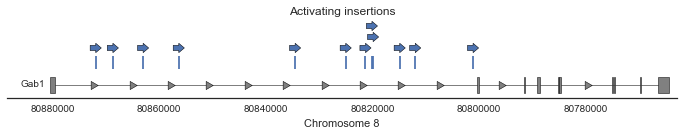

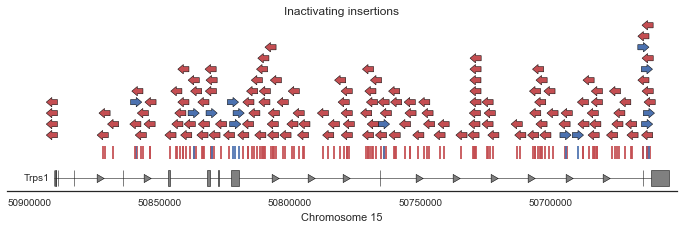

In [12]:
from nbsupport import insertions as nb_ins

# Get reference gtf file.
gtf_path = ('/Volumes/Datastore/References/mus_musculus/mm10'
            '/gtf/Mus_musculus.GRCm38.76.gtf.gz')

# Draw transcripts.
genes = [('Gab1', (8000, 1500), 'Activating insertions'),
         ('Trps1', (18000, 3000), 'Inactivating insertions')]

for gene_name, padding, title in genes:
    fig = nb_ins.plot_insertion_track_gtf(
        insertions, gtf_path, gene_name=gene_name,
        padding=padding, figsize=(12, None))
    fig.axes[0].set_title(title)

In [13]:
# Draw again for paper.
genes = [('Gab1', (8000, 1500), 'Activating insertions'),
         ('Trps1', (18000, 3000), 'Inactivating insertions')]

track_kws = {
    'gene': {
        'height': 0.12, 
        'arrow_size': 20,
        'arrow_spacing': 20,
        'plot_kws': {'lw': 0.3},
        'label_kws': {'fontsize': 6,
                      'fontstyle': 'italic'}
    },
    'insertions': {
       'height': 0.1,
       'plot_kws': {'lw': 0.2}
    },
    'rug': {
        'height': 0.1
    }
}

with sns.plotting_context('paper', font_scale=0.7):
    for gene_name, padding, title in genes:
        fig = nb_ins.plot_insertion_track_gtf(
            insertions, gtf_path, gene_name=gene_name,
            padding=padding, figsize=(9, None), track_kws=track_kws, ins_size=1/180)

        fig.axes[0].set_title(title)
        
        fig.savefig('../reports/supplemental/figures/fig_s5_{}.pdf'
                    .format(gene_name), bbox_inches='tight')
        plt.close(fig)

## IM-Fusion diff-expression

In [14]:
from pathlib import Path

from imfusion.expression.de_test import de_exon
from imfusion.util.tabix import GtfFile as ImfGtfFile


dexseq_path = Path('/Users/Julian/References/mus_musculus/mm10/gtf/'
                   'DEXSeq/Mus_musculus.GRCm38.76.DEXSeq.no_aggr.gtf.gz')

exon_counts_path = '../data/processed/expression/exon_counts.sb.imf.txt'


gene_id_map = dict(zip(insertions['gene_name'], insertions['gene_id']))

ranked_genes = (
    nb_ins.gene_statistics(insertions)
          .query('n_samples > 5')
          .sort_values('n_samples', ascending=False)
          .reset_index()
          .assign(gene_id=lambda df: df['gene_name'].map(gene_id_map)))


# Test DEs.
results = {
    row.gene_name: de_exon(
        insertions.rename(columns={'sample': 'sample_id'}),
        gene_id=row.gene_id, dexseq_gtf=ImfGtfFile(dexseq_path),
        exon_counts=exon_counts_path)
    for _, row in ranked_genes.iterrows()}

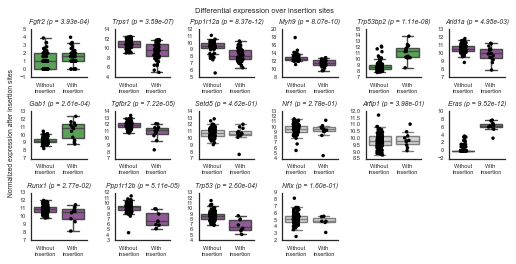

In [25]:
with sns.plotting_context('paper', font_scale=0.7):
    # Plot DE.
    fig, axes = plt.subplots(ncols=6, nrows=3, figsize=(7, 3.5), sharex=False)

    sel_genes = ranked_genes.query('n_samples >= 8')['gene_name']
    for (gene_name, ax) in zip(sel_genes, axes.flatten()):
        result = results[gene_name]

        if result.p_value <= 0.05:
            if result.direction == 1:
                color = sns.color_palette('Set1')[2]
            else:
                color = sns.color_palette('Set1')[3]
        else:
            color = 'lightgrey'
        
        result.plot_boxplot(log=True, ax=ax, color=color)
        ax.set_title('{} (p = {:.2e})'.format(gene_name, result.p_value),
                     fontstyle='italic')

        ax.set_xlabel('')
        ax.set_ylabel('')
        
    for ax in axes.flatten():
        ax.set_xticklabels(['Without\ninsertion', 'With\ninsertion'])

    fig.suptitle('Differential expression over insertion sites',
                 fontsize=7.5, y=1.02)
    fig.tight_layout()

    sns.despine(fig)

    fig.text(s='Normalized expression after insertion sites',
             rotation=90, x=-0.01, y=0.52, va='center')
    
    axes[-1, -1].axis('off')
    axes[-1, -2].axis('off')
    
fig.savefig('../reports/supplemental/figures/fig_s5_diff_expr.pdf', bbox_inches='tight')

# KEGG enrichment

In [26]:
from nbsupport.enrichment import genesets as nb_genes

# Fetch gene sets and translate to symbol.
kegg_sets = nb_genes.kegg.get_gene_sets('mmu')
kegg_sets = nb_genes.map_sets(
    kegg_sets, from_type='entrez', to_type='symbol',
    from_organism='mmusculus', mapper='ensembl')

# Test for enrichment.
genes = set(insertions['gene_name'])

result = nb_genes.test_sets(
    set(insertions['gene_name']), kegg_sets,
    corr_method='fdr_bh', include_overlap=True)

result_sign = (
    result.query('p_value_corr < 0.1')
          .sort_values(['p_value', 'p_value_corr']))

result_sign

,gene_set,p_value,p_value_corr,overlap
64,MAPK signaling pathway,0.000008,0.002155,"Fgfr2, Nf1, Rasa1, Rasgrf1, Tgfbr2, Trp53"
89,Chronic myeloid leukemia,0.000014,0.002155,"Cblb, Runx1, Tgfbr2, Trp53"
157,Proteoglycans in cancer,0.000046,0.004638,"Cblb, Gab1, Ppp1r12a, Ppp1r12b, Trp53"
252,Ras signaling pathway,0.000081,0.006110,"Fgfr2, Gab1, Nf1, Rasa1, Rasgrf1"
20,EGFR tyrosine kinase inhibitor resistance,0.000608,0.036738,"Fgfr2, Gab1, Nf1"
17,Regulation of actin cytoskeleton,0.000943,0.044146,"Fgfr2, Myh9, Ppp1r12a, Ppp1r12b"
70,Pathways in cancer,0.001023,0.044146,"Cblb, Fgfr2, Runx1, Tgfbr2, Trp53"
241,Neurotrophin signaling pathway,0.002117,0.079921,"Gab1, Trp53, Ywhae"


In [27]:
result.ix[result['gene_set'].str.contains('PI3K')]

,gene_set,p_value,p_value_corr,overlap
187,PI3K-Akt signaling pathway,0.032355,0.444544,"Fgfr2, Trp53, Ywhae"


In [28]:
(result_sign.rename(columns={'gene_set': 'Gene set',
                             'p_value': 'p-value',
                             'p_value_corr': 'FDR',
                             'overlap': 'Overlapping genes'})
            .to_excel('../reports/tables/table_1_kegg.xlsx', index=False))

# Mutual exclusivity

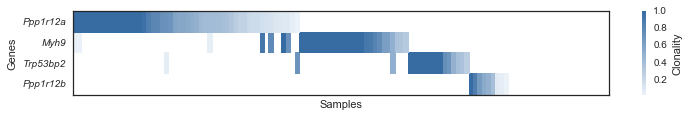

In [29]:
mutex_genes = ['Ppp1r12a', 'Myh9', 'Trp53bp2', 'Ppp1r12b']

fig, ax = plt.subplots(figsize=(12, 1.5))
nb_ins.plot_insertion_matrix(insertions, genes=mutex_genes, ax=ax);

with sns.plotting_context('paper', font_scale=0.7):
    fig, ax = plt.subplots(figsize=(9.6, 0.75))
    nb_ins.plot_insertion_matrix(insertions, genes=mutex_genes, ax=ax)

fig.savefig('../reports/figures/fig_3_mutex.pdf', bbox_inches='tight')
plt.close(fig)

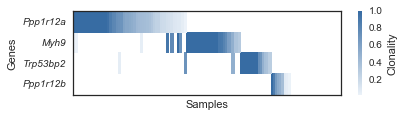

In [30]:
mutex_genes = ['Ppp1r12a', 'Myh9', 'Trp53bp2', 'Ppp1r12b']

fig, ax = plt.subplots(figsize=(6, 1.5))
nb_ins.plot_insertion_matrix(insertions, genes=mutex_genes, ax=ax);

with sns.plotting_context('paper', font_scale=0.7):
    fig, ax = plt.subplots(figsize=(3.8, 0.75))
    nb_ins.plot_insertion_matrix(insertions, genes=mutex_genes, ax=ax)

fig.savefig('../reports/figures/fig_3_mutex_v2.pdf', bbox_inches='tight')
plt.close(fig)